# Compare Explanation

### 0. Load packages

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from datetime import date

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import auc, precision_recall_curve

from sktime.classification.shapelet_based import MrSEQLClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from pyts.transformation import WEASEL
from sklearn.metrics import accuracy_score

from scripts.Noise import Noise
from scripts.Explanation import GetExplanation, reshape_lime_explanation, load_explanation, create_random_explanation
import utils.visualization as vis
from utils.data import LocalDataLoader, data_summary
from scripts.Experiment import Evaluate
from scripts.CompareExplanation import CompareExplanation, run_experiment, get_final_ranking, summarize_auc

import warnings
warnings.filterwarnings(action='ignore')

%load_ext autoreload
%autoreload 2

In [13]:
def rescale_saliency(explainer_saliency):
    """Rescales saliency 2D-numpy array by range
    """
    explainer_saliency = abs(explainer_saliency)
    min_, max_ = explainer_saliency.min(axis=1).reshape(-1,1), explainer_saliency.max(axis=1).reshape(-1,1)
    explainer_saliency_rescaled =  (explainer_saliency-min_) / (max_ - min_)
    return explainer_saliency_rescaled 

def filter_invalid_saliency(explainer_saliency,true_saliency):
    """ Filter out invalid (NaN) type of explainer saliency array 
    """
    
    invalid = np.isnan(np.sum(explainer_saliency,axis=1))
    if sum(invalid)>0:
        true_saliency = true_saliency[invalid==False]
        explainer_saliency = explainer_saliency[invalid==False]
    return explainer_saliency,true_saliency

def index_to_label(start_end_array, n_steps=50):
    """Converts from true saliency with start and end values to a 0,1 numpy array
    """
    ans = list(np.zeros(shape=(start_end_array.shape[0],n_steps)))
    start_end_array = list(start_end_array)
    for i, val in enumerate(start_end_array):
        start, end = int(val[0]), int(val[1])
        for j in range(start,end):
            ans[i][j] = 1
        
    return np.array(ans)



def eval_saliency_synthetic(ds,prec_recall=True,subset=True,n=20, threshold=0.5):
    """Evaluates a subset of dataset with known ground truth. This function is not properly written at this stage of experiment.
    """
    print(ds)
    data = np.load('data/synth/'+ds+'_TEST_meta.npy')
    true_saliency_index = data[:,1:3]
    
    true_saliency_original = index_to_label(true_saliency_index)
    no_examples = n if subset else true_saliency_original.shape[1]
    true_saliency_original = true_saliency_original[:no_examples,:]
    xais = [
        'GradientShap',
            'IG',
        'LIME',
        'ROCKET',
        'MrSEQL',
        'random2020'
           ] 
    lime_xais = ['lime','LIME','Lime','ROCKET']
    
    for xai in xais:
        if xai == 'random2020':
            explainer_saliency, random_weight_name = create_random_explanation(datapath=ds_dir,dataset=ds)
        else:
            is_reshape=True if xai in lime_xais else False
            explainer_saliency = load_explanation(datapath=ds_dir,dataset=ds,explanation_type=xai,reshape_lime=is_reshape,
                                                 evaluation_on_subset=False, eval_size=0)

        explainer_saliency = explainer_saliency[:no_examples,:]
        explainer_saliency=rescale_saliency(explainer_saliency)
        explainer_saliency,true_saliency = filter_invalid_saliency(explainer_saliency,true_saliency_original)
        if prec_recall:
            explainer_saliency = explainer_saliency >= threshold
            aup = metrics.precision_score(true_saliency.flatten() ,explainer_saliency.flatten())
            aur = metrics.recall_score(true_saliency.flatten() ,explainer_saliency.flatten())
            print('Precision, Recall of method ', xai, ': ', round(aup,4),'; ', round(aur,4))
        else:
            prec, rec, thres = precision_recall_curve(true_saliency.flatten(), explainer_saliency.flatten())
            aup = auc(thres, prec[1:])
            aur = auc(thres, rec[1:])
            print('AUP, AUR of method ', xai, ': ', round(aup,4),'; ', round(aur,4))

    

In [14]:
xais = ['LIME', 'MrSEQL','GradientShap','IG','ROCKET'] 
names =[ 'lime_mrseql', 'mrseql','GS','IG','lime_rocket']

referees = ['rocket','resnet','knn','MrSEQLClassifier',]
noise_types = ['global_mean','local_mean']

########### Dont change here ############
assert len(xais) == len(names)
random_seeds = [2020]
lime_xais = ['lime','LIME','Lime','ROCKET']

In [41]:
import itertools
from itertools import product

list_1 = ['SmallMiddle_', 'RareTime_', 'Moving_SmallMiddle','Moving_RareTime_']
list_2 = ['CAR', 'NARMA', 'Harmonic', 'PseudoPeriodic']

output = list(product(list_1, list_2))

ans = []
for i1, i2 in output:
    ans.append(''.join((i1,i2)))

    

### 1. Data Summary

In [20]:


ds_list = [
    'SmallMiddle_CAR','SmallMiddle_NARMA',
    'RareTime_CAR','RareTime_NARMA',
    'Moving_RareTime_CAR',
    'Moving_RareTime_Harmonic','Moving_RareTime_PseudoPeriodic',
#     need: 'Moving_RareTime_NARMA', 'Moving_SmallMiddle_CAR',
#     need: 'RareTime_Harmonic', 'RareTime_PseudoPeriodic'
    
          ]
ds_dir = 'data'
ds = ds_list[0]

Middle_CAR
Dataset: Middle_CAR
X_train.shape:  (500, 1, 50)
X_test.shape:  (100, 1, 50)
Unique target class:  ['0', '1']
Dataset: Middle_CAR, Training Data-Global mean value: 0.04016


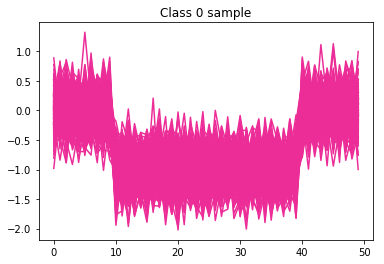

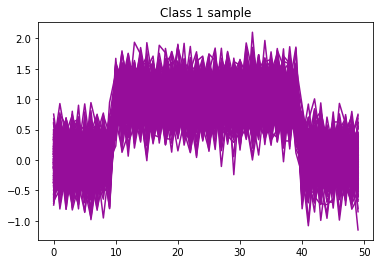

------------------------------


In [30]:
ds = 'Middle_CAR'
print(ds)
data_summary(ds_dir,ds)
print('------------------------------')



# for ds in ds_list:
#     print(ds)
#     data_summary(ds_dir,ds)
#     print('------------------------------')

# data = LocalDataLoader(ds_dir,ds)
# _,_,X_test,y_test = data.get_X_y()
# X_test.shape[-1]

In [17]:
X_test.shape

(100, 1, 50)

(500, 50)
(100, 50)


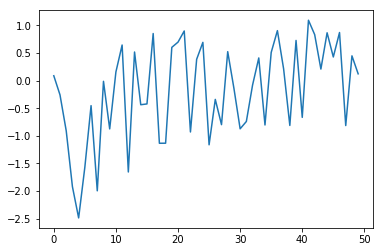

In [18]:
ds = ds_list[0]
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
X_train=np.squeeze(X_train)
X_test=np.squeeze(X_test)
print(X_train.shape)
print(X_test.shape)
plt.plot(X_test[0])

### 2. Precision/Recall


In [19]:
"""Evaluates a subset of dataset, default by precision/recall with threshold 0.5 and subset size = 20 examples
"""
# #################################################
for ds in ds_list:
    eval_saliency_synthetic(ds)

Moving_RareTime_Harmonic
Precision, Recall of method  GradientShap :  0.6 ;  0.4
Precision, Recall of method  IG :  0.9038 ;  0.3917
(100, 10)
(100, 1, 50)
Precision, Recall of method  LIME :  0.1795 ;  0.5833
File path not exists


OSError: exp_weights/weights_ROCKET_Moving_RareTime_Harmonic.txt not found.

### 3. GroundTruth for subset of data

In [213]:
ds = ds_list[1]
print(ds)
# Load weights
weights = []
for xai in xais:
    is_reshape=True if xai in lime_xais else False
    weight = load_explanation(datapath=ds_dir,dataset=ds,explanation_type=xai,reshape_lime=is_reshape)
    weights.append(weight)

for seed in random_seeds:
    random_weight, random_weight_name = create_random_explanation(datapath=ds_dir,dataset=ds)
    weights.append(random_weight)
    names.append(random_weight_name)


print('Explanation Shape: ', weights[0].shape)
print('Total numbers of XAI Methods: ', len(weights))
print('Names of XAI Methods: ', names)


RareTime_NARMA
Explanation Shape:  (100, 50)
Total numbers of XAI Methods:  6
Names of XAI Methods:  ['lime_mrseql', 'mrseql', 'GS', 'IG', 'lime_rocket', 'random2020']


##### 3.1. LimeRocket explanation

RareTime_NARMA
Index 0 ; True Class 0


Index 1 ; True Class 0


Index 2 ; True Class 1


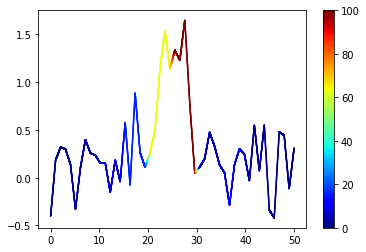

Index 3 ; True Class 1


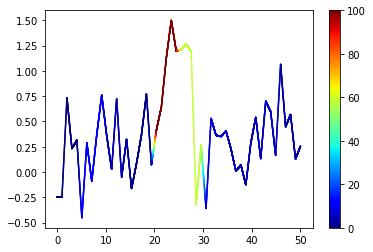

Index 4 ; True Class 0


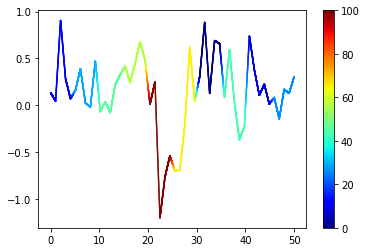

Index 5 ; True Class 1


Index 6 ; True Class 0


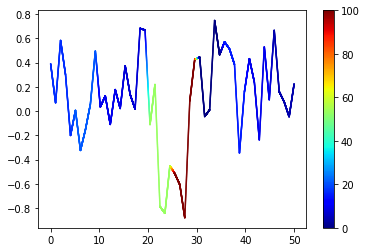

Index 7 ; True Class 1


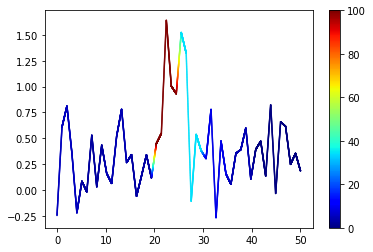

Index 8 ; True Class 0


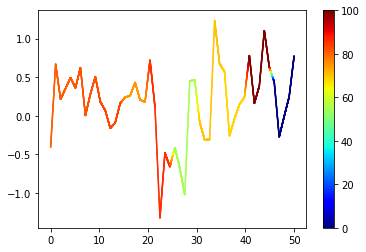

Index 9 ; True Class 1


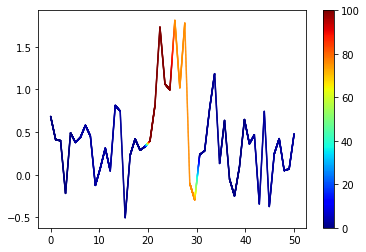

Index 10 ; True Class 1


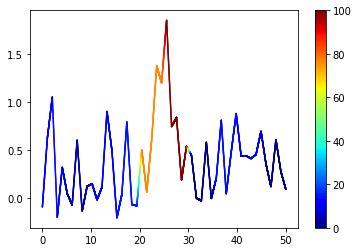

Index 11 ; True Class 0


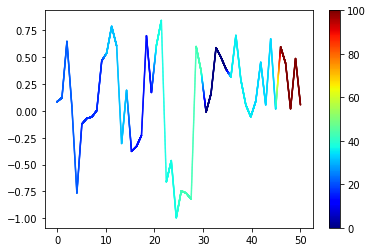

Index 12 ; True Class 0


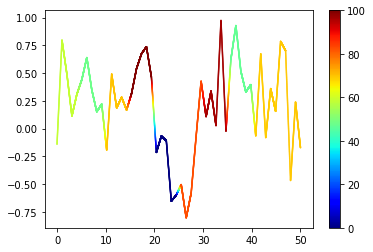

Index 13 ; True Class 1


Index 14 ; True Class 0


Index 15 ; True Class 0


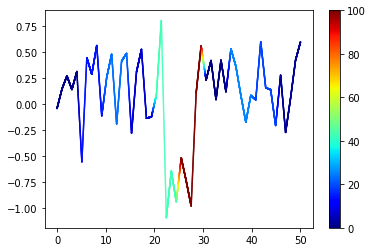

Index 16 ; True Class 1


Index 17 ; True Class 1


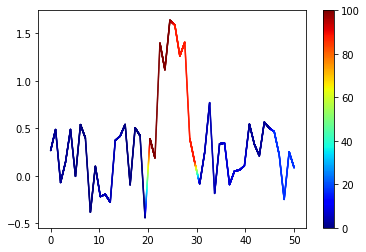

Index 18 ; True Class 0


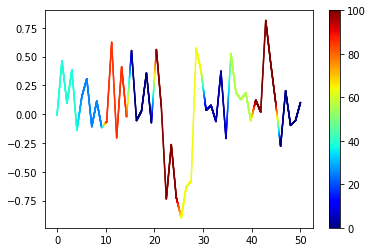

Index 19 ; True Class 0


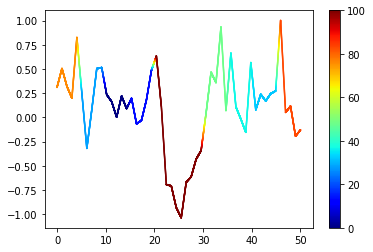

In [197]:
print(ds)
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
exp = weights[-2]
for i in range(len(X_test)+1):
    if i <20:
        print('Index %d ; True Class %d' %(i,y_test[i]))
        vis.visualize_explanation(i,X_test,exp,ds=ds)


##### 3.2. MrSEQL Explanation

Index 0 ; True Class 0


Index 1 ; True Class 0


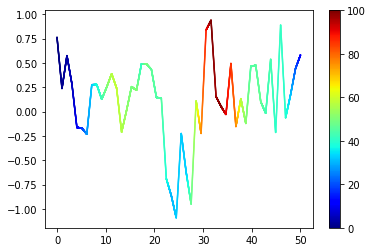

Index 2 ; True Class 1


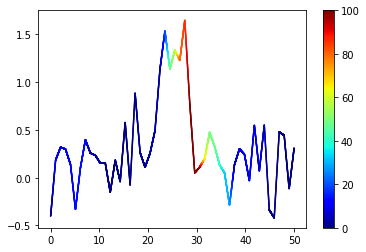

Index 3 ; True Class 1


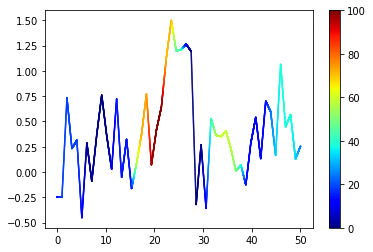

Index 4 ; True Class 0


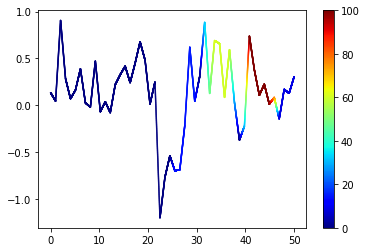

Index 5 ; True Class 1


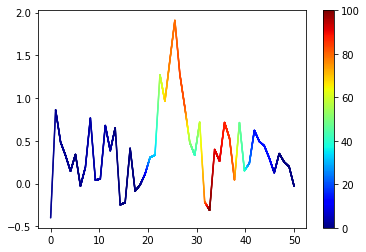

Index 6 ; True Class 0


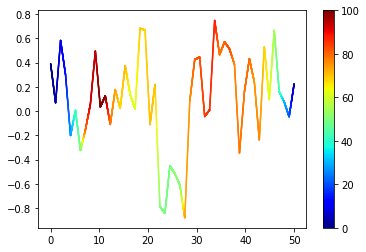

Index 7 ; True Class 1


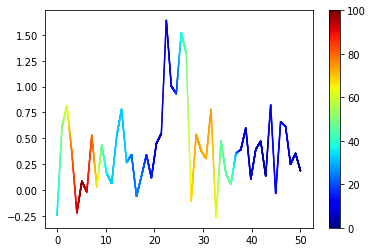

Index 8 ; True Class 0


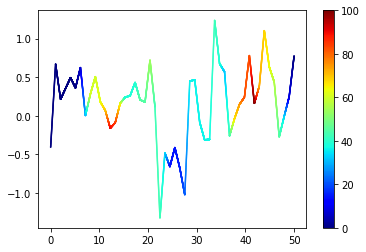

Index 9 ; True Class 1


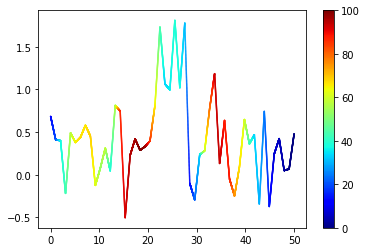

Index 10 ; True Class 1


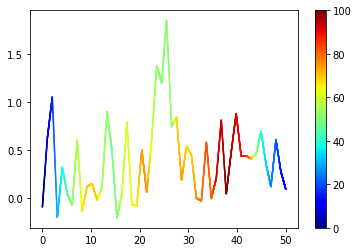

Index 11 ; True Class 0


Index 12 ; True Class 0


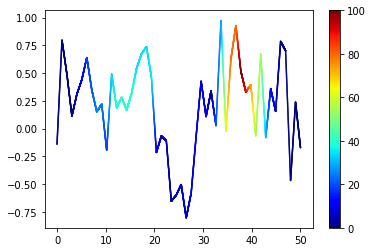

Index 13 ; True Class 1


Index 14 ; True Class 0


Index 15 ; True Class 0


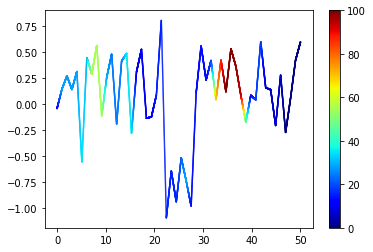

Index 16 ; True Class 1


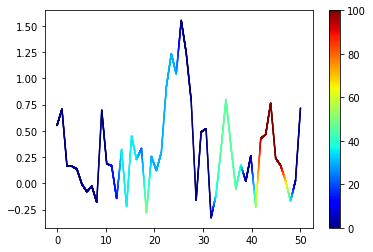

Index 17 ; True Class 1


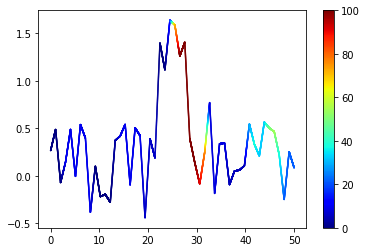

Index 18 ; True Class 0


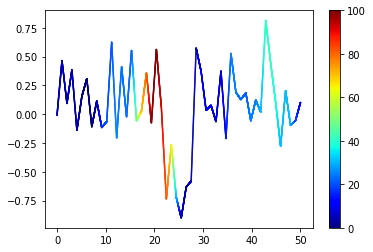

Index 19 ; True Class 0


In [198]:
# print(ds)
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
exp = weights[1]
for i in range(len(X_test)+1):
    if i < 20:
        print('Index %d ; True Class %d' %(i,y_test[i]))
        vis.visualize_explanation(i,X_test,exp,ds=ds)


##### 3.3 GradientShap explanation

Index 0 ; True Class 0


Index 1 ; True Class 0


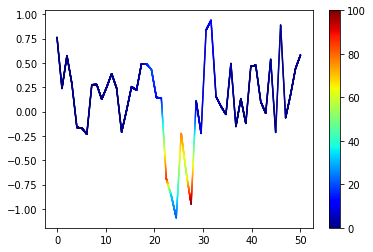

Index 2 ; True Class 1


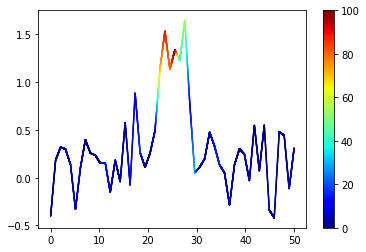

Index 3 ; True Class 1


Index 4 ; True Class 0


Index 5 ; True Class 1


Index 6 ; True Class 0


Index 7 ; True Class 1


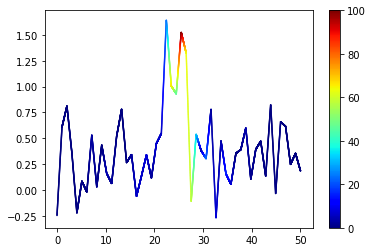

Index 8 ; True Class 0


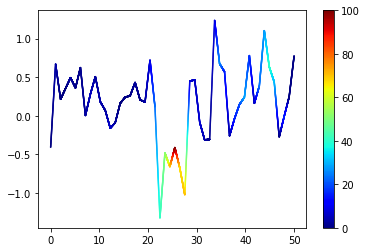

Index 9 ; True Class 1


Index 10 ; True Class 1


Index 11 ; True Class 0


Index 12 ; True Class 0


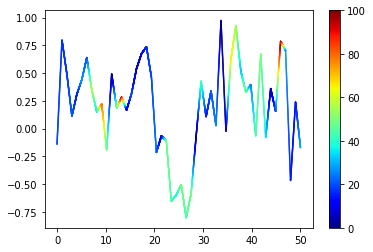

Index 13 ; True Class 1


Index 14 ; True Class 0


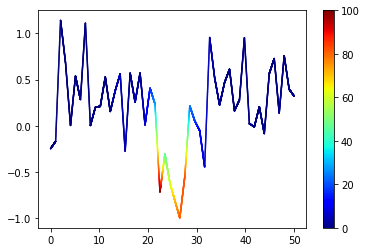

Index 15 ; True Class 0


Index 16 ; True Class 1


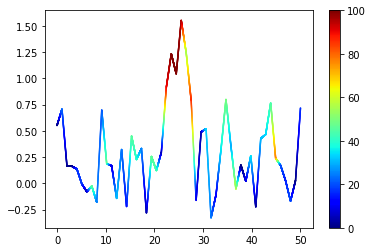

Index 17 ; True Class 1


Index 18 ; True Class 0


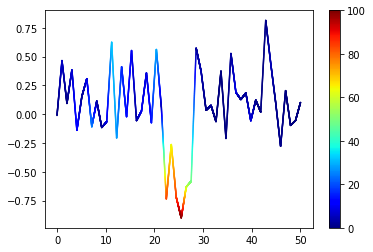

Index 19 ; True Class 0


In [199]:
# print(ds)
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
exp = weights[2]
for i in range(len(X_test)+1):
    if i < 20:
        print('Index %d ; True Class %d' %(i,y_test[i]))
        vis.visualize_explanation(i,X_test,exp,ds=ds)


##### 3.4 Random explanation

RareTime_NARMA
Index 0 ; True Class 0


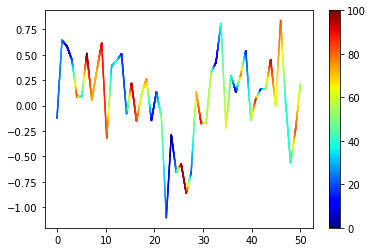

Index 1 ; True Class 0


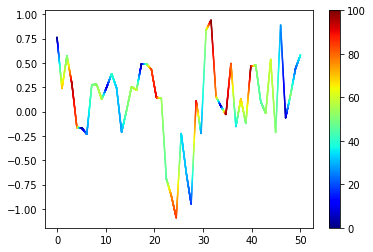

Index 2 ; True Class 1


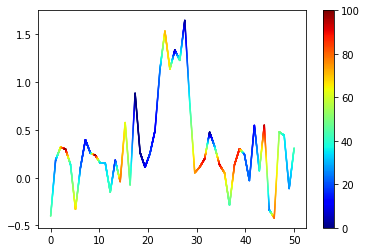

Index 3 ; True Class 1


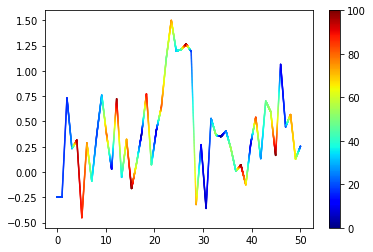

Index 4 ; True Class 0


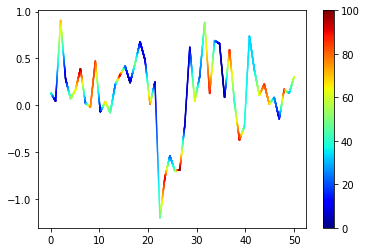

Index 5 ; True Class 1


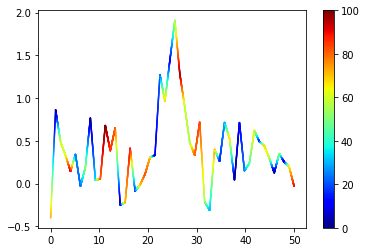

Index 6 ; True Class 0


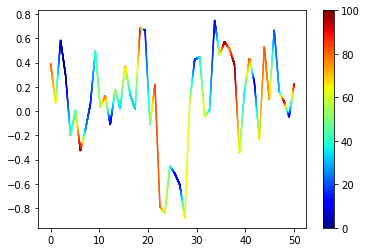

Index 7 ; True Class 1


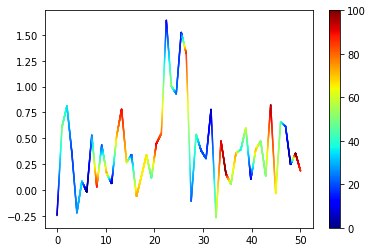

Index 8 ; True Class 0


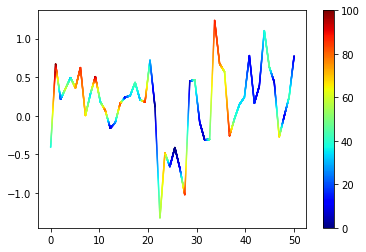

Index 9 ; True Class 1


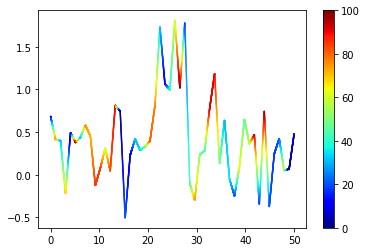

Index 10 ; True Class 1


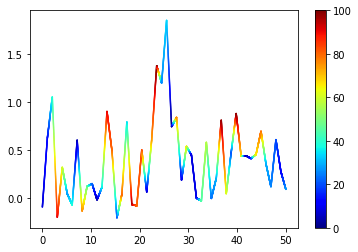

Index 11 ; True Class 0


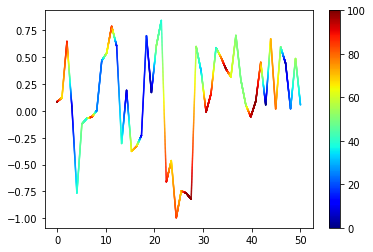

Index 12 ; True Class 0


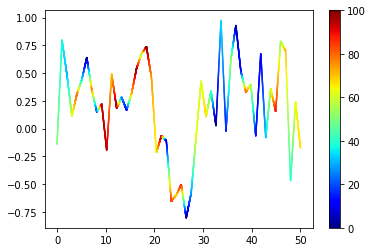

Index 13 ; True Class 1


Index 14 ; True Class 0


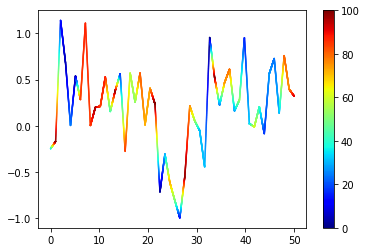

Index 15 ; True Class 0


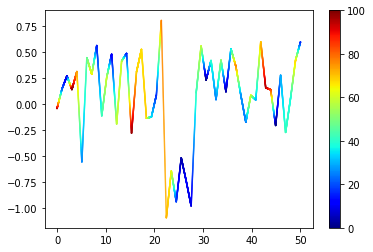

Index 16 ; True Class 1


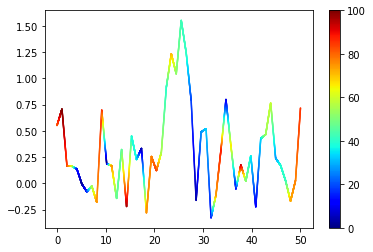

Index 17 ; True Class 1


Index 18 ; True Class 0


Index 19 ; True Class 0


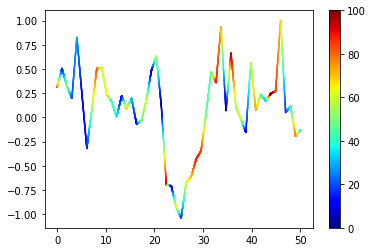

In [200]:
print(ds)
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
exp = weights[-1]
for i in range(len(X_test)+1):
    if i < 20:
        print('Index %d ; True Class %d' %(i,y_test[i]))
        vis.visualize_explanation(i,X_test,exp,ds=ds)


##### 3.4 Lime(MrSEQL) explanation

RareTime_NARMA
Index 0 ; True Class 0


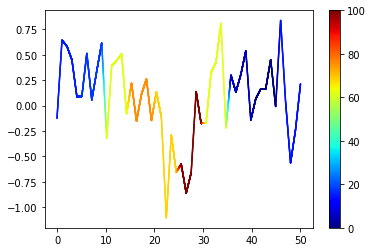

Index 1 ; True Class 0


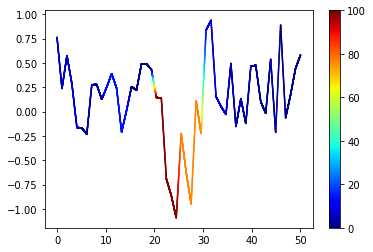

Index 2 ; True Class 1


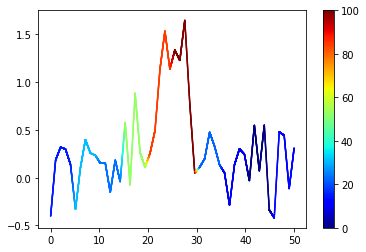

Index 3 ; True Class 1


Index 4 ; True Class 0


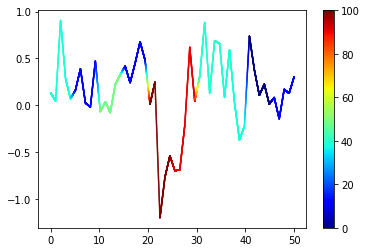

Index 5 ; True Class 1


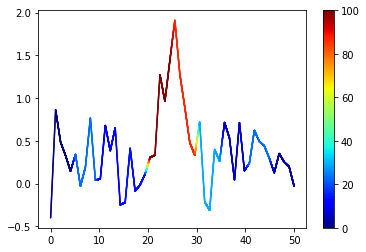

Index 6 ; True Class 0


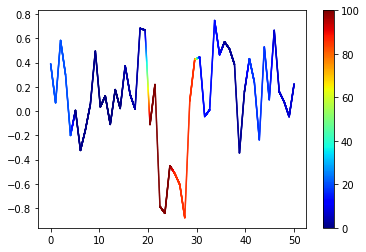

Index 7 ; True Class 1


Index 8 ; True Class 0


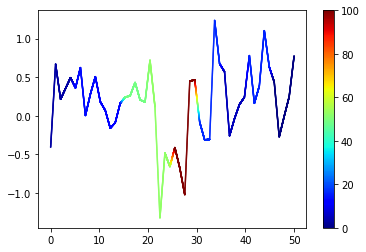

Index 9 ; True Class 1


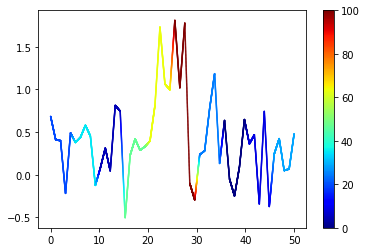

Index 10 ; True Class 1


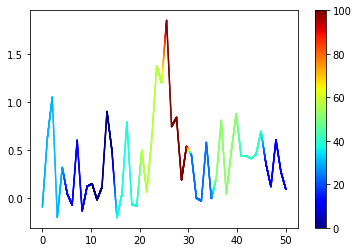

Index 11 ; True Class 0


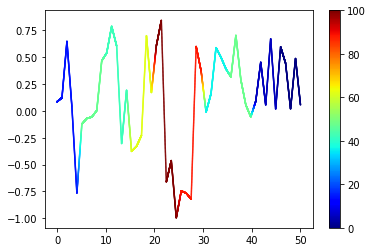

Index 12 ; True Class 0


Index 13 ; True Class 1


Index 14 ; True Class 0


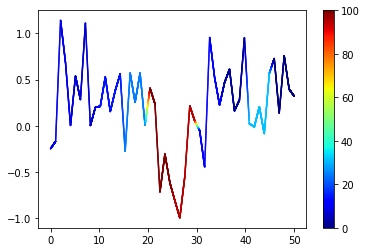

Index 15 ; True Class 0


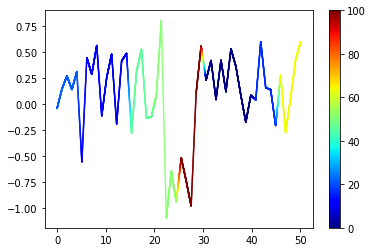

Index 16 ; True Class 1


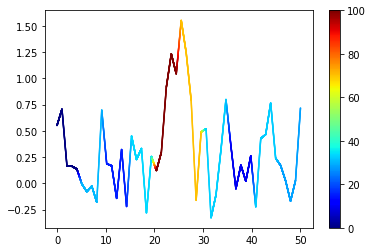

Index 17 ; True Class 1


Index 18 ; True Class 0


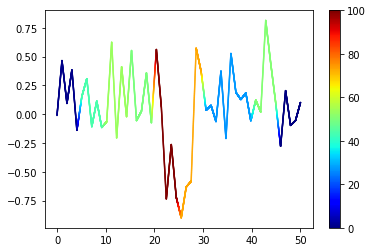

Index 19 ; True Class 0


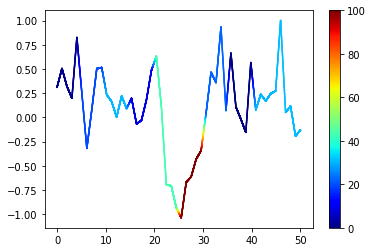

In [210]:
print(ds)
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
exp = weights[0]
for i in range(len(X_test)+1):
    if i < 20:
        print('Index %d ; True Class %d' %(i,y_test[i]))
        vis.visualize_explanation(i,X_test,exp,ds=ds)


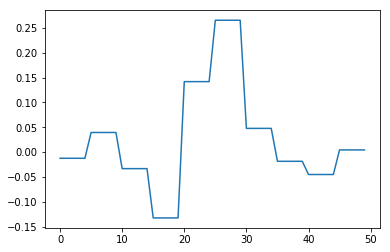

In [212]:
plt.plot(weights[0][8])

### 3. GroundTruth for subset of data (dataset SmallMiddle_CAR)

In [223]:
names =[ 'lime_mrseql', 'mrseql','GS','IG','lime_rocket']

ds = ds_list[0]
print(ds)

# Load weights
weights = []
for xai in xais:
    is_reshape=True if xai in lime_xais else False
    weight = load_explanation(datapath=ds_dir,dataset=ds,explanation_type=xai,reshape_lime=is_reshape)
    weights.append(weight)

for seed in random_seeds:
    random_weight, random_weight_name = create_random_explanation(datapath=ds_dir,dataset=ds)
    weights.append(random_weight)
    names.append(random_weight_name)


print('Explanation Shape: ', weights[0].shape)
print('Total numbers of XAI Methods: ', len(weights))
print('Names of XAI Methods: ', names)


SmallMiddle_CAR
Explanation Shape:  (100, 50)
Total numbers of XAI Methods:  6
Names of XAI Methods:  ['lime_mrseql', 'mrseql', 'GS', 'IG', 'lime_rocket', 'random2020']


##### 3.1. LimeRocket explanation

SmallMiddle_CAR
Index 0 ; True Class 0


Index 1 ; True Class 0


Index 2 ; True Class 0


Index 3 ; True Class 0


Index 4 ; True Class 0


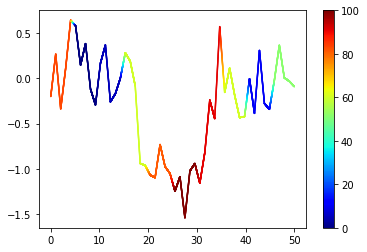

Index 5 ; True Class 0


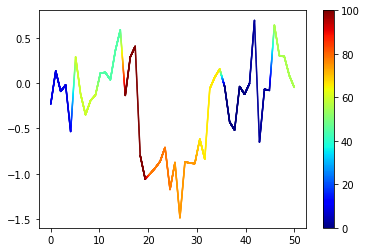

Index 6 ; True Class 1


Index 7 ; True Class 0


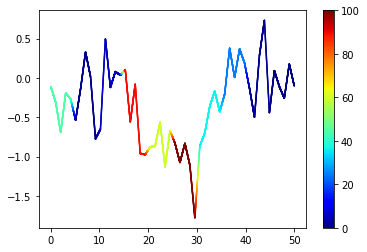

Index 8 ; True Class 0


Index 9 ; True Class 0


Index 10 ; True Class 0


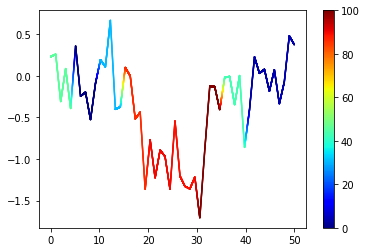

Index 11 ; True Class 0


Index 12 ; True Class 1


Index 13 ; True Class 1


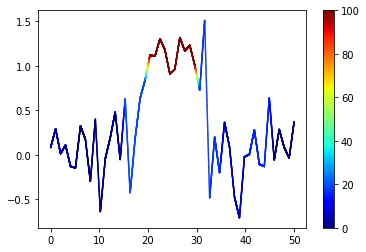

Index 14 ; True Class 0


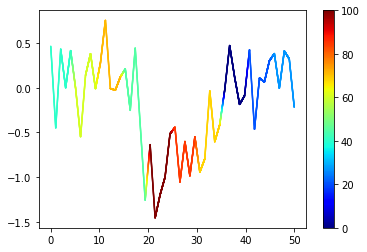

Index 15 ; True Class 1


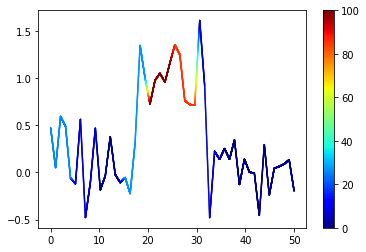

Index 16 ; True Class 1


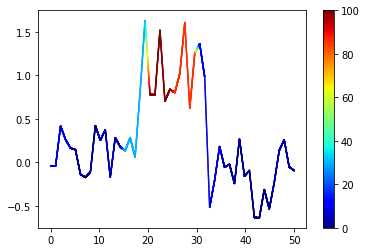

Index 17 ; True Class 0


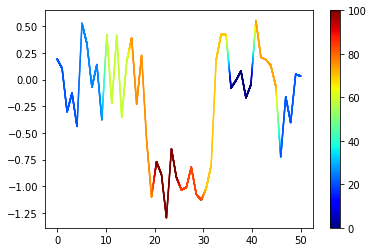

Index 18 ; True Class 0


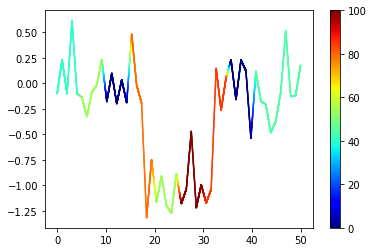

Index 19 ; True Class 0


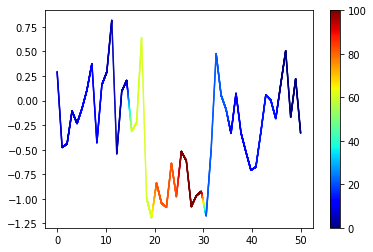

In [215]:
print(ds)
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
exp = weights[-2]
for i in range(len(X_test)+1):
    if i <20:
        print('Index %d ; True Class %d' %(i,y_test[i]))
        vis.visualize_explanation(i,X_test,exp,ds=ds)


##### 3.2. MrSEQL Explanation

Index 0 ; True Class 0


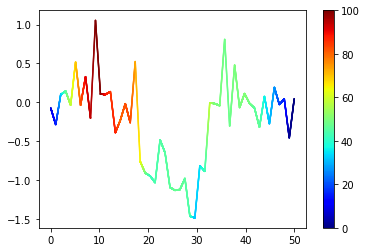

Index 1 ; True Class 0


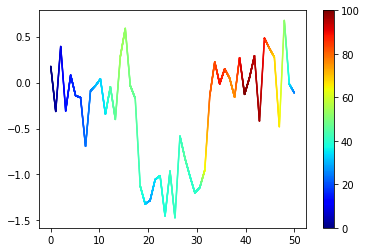

Index 2 ; True Class 0


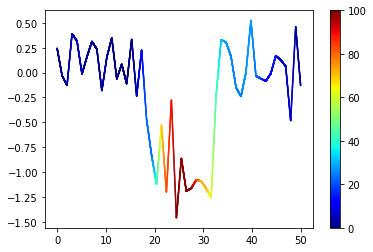

Index 3 ; True Class 0


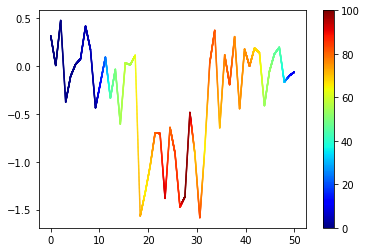

Index 4 ; True Class 0


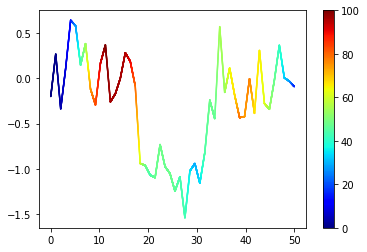

Index 5 ; True Class 0


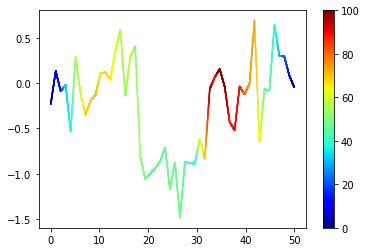

Index 6 ; True Class 1


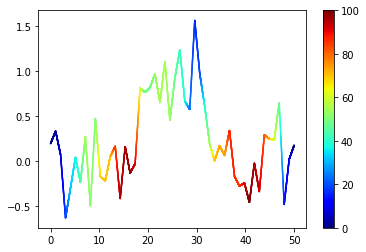

Index 7 ; True Class 0


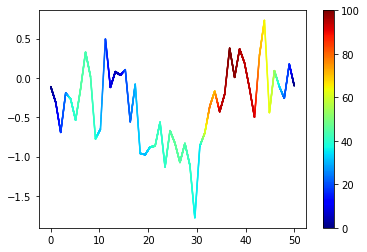

Index 8 ; True Class 0


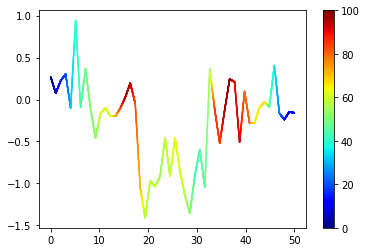

Index 9 ; True Class 0


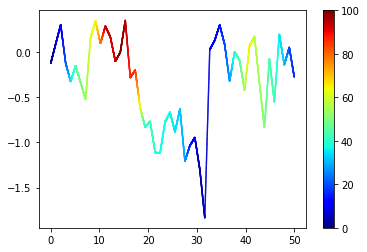

Index 10 ; True Class 0


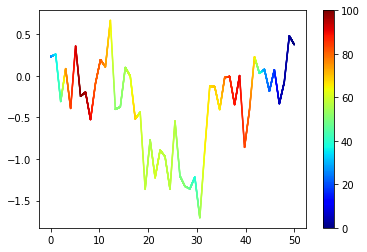

Index 11 ; True Class 0


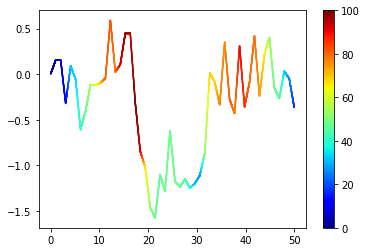

Index 12 ; True Class 1


Index 13 ; True Class 1


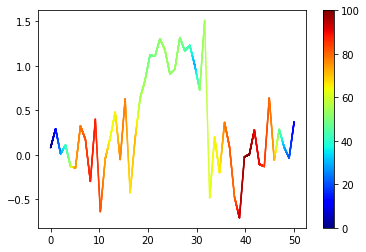

Index 14 ; True Class 0


Index 15 ; True Class 1


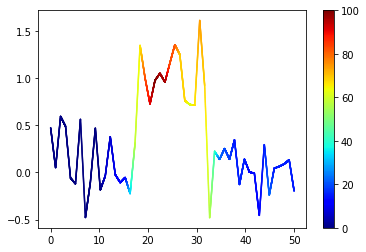

Index 16 ; True Class 1


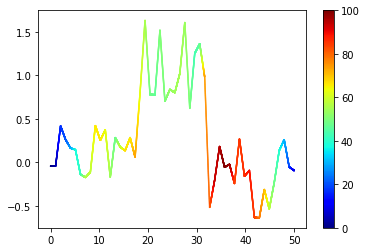

Index 17 ; True Class 0


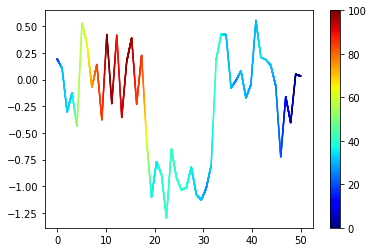

Index 18 ; True Class 0


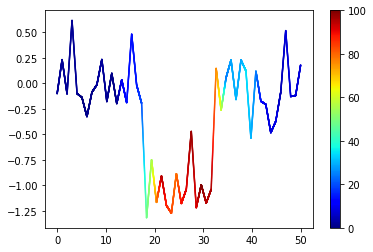

Index 19 ; True Class 0


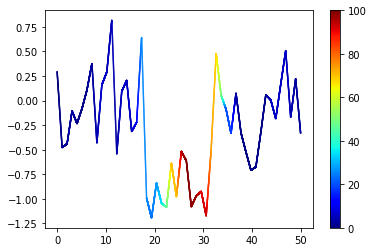

In [216]:
# print(ds)
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
exp = weights[1]
for i in range(len(X_test)+1):
    if i < 20:
        print('Index %d ; True Class %d' %(i,y_test[i]))
        vis.visualize_explanation(i,X_test,exp,ds=ds)


##### 3.3 GradientShap explanation

Index 0 ; True Class 0


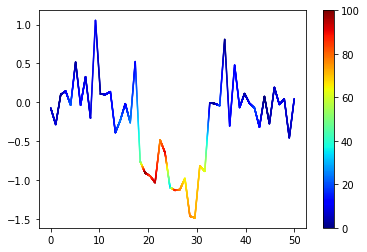

Index 1 ; True Class 0


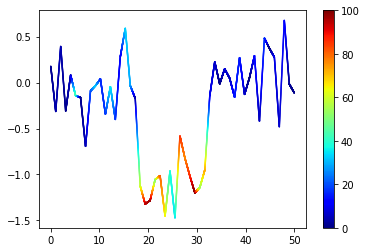

Index 2 ; True Class 0


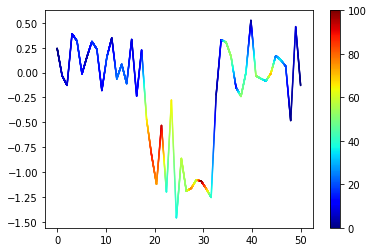

Index 3 ; True Class 0


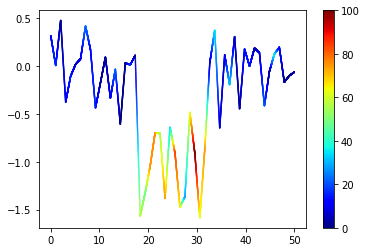

Index 4 ; True Class 0


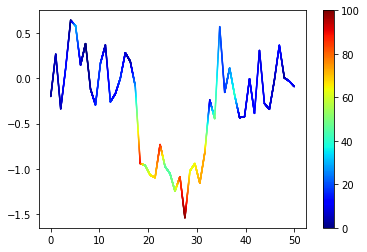

Index 5 ; True Class 0


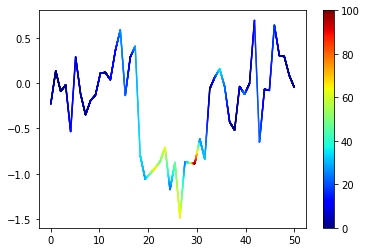

Index 6 ; True Class 1


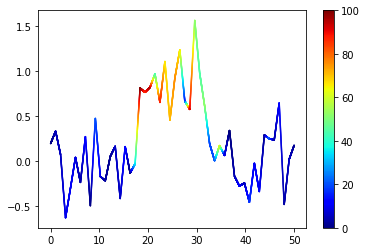

Index 7 ; True Class 0


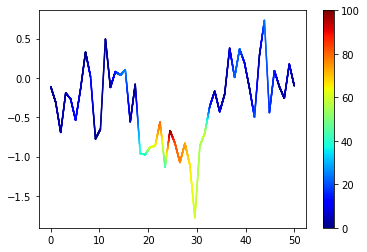

Index 8 ; True Class 0


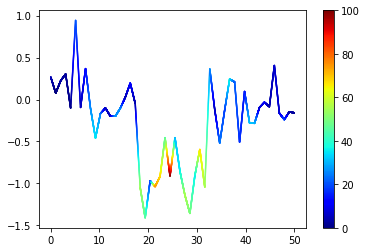

Index 9 ; True Class 0


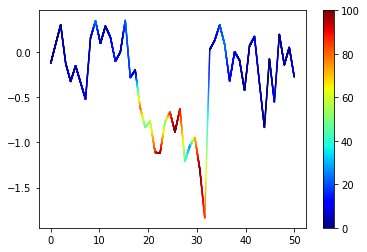

Index 10 ; True Class 0


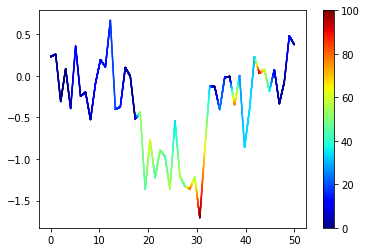

Index 11 ; True Class 0


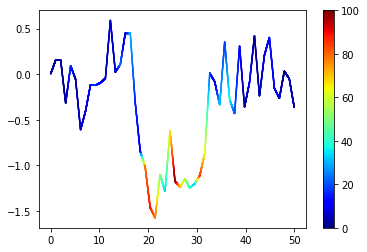

Index 12 ; True Class 1


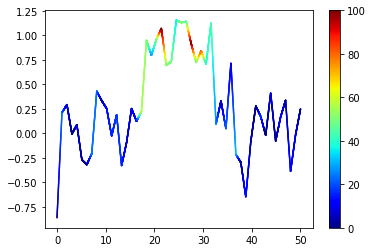

Index 13 ; True Class 1


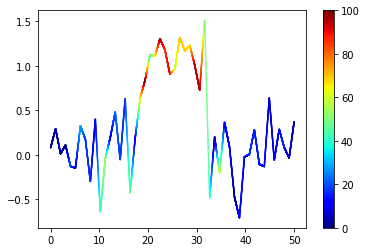

Index 14 ; True Class 0


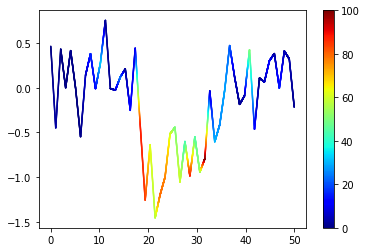

Index 15 ; True Class 1


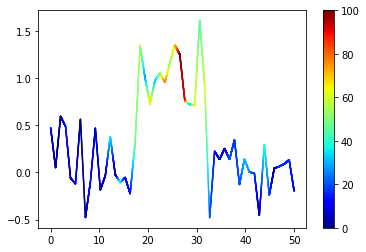

Index 16 ; True Class 1


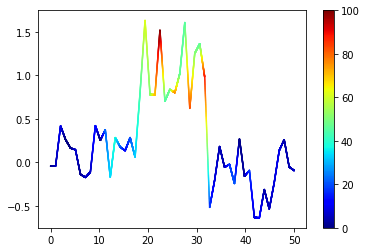

Index 17 ; True Class 0


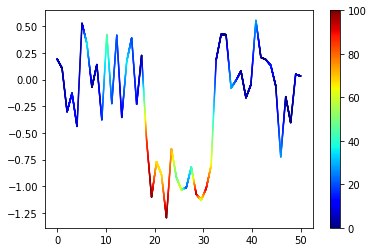

Index 18 ; True Class 0


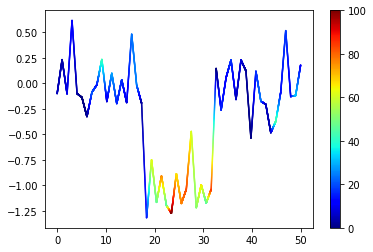

Index 19 ; True Class 0


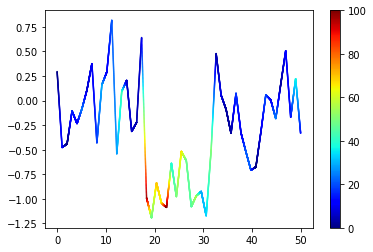

In [217]:
# print(ds)
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
exp = weights[2]
for i in range(len(X_test)+1):
    if i < 20:
        print('Index %d ; True Class %d' %(i,y_test[i]))
        vis.visualize_explanation(i,X_test,exp,ds=ds)


##### 3.4 Random explanation

SmallMiddle_CAR
Index 0 ; True Class 0


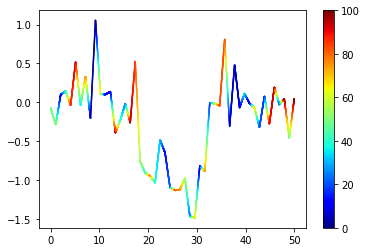

Index 1 ; True Class 0


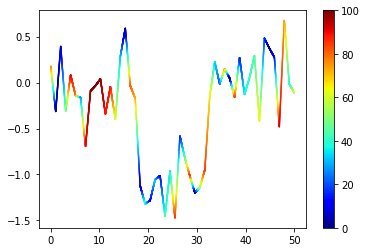

Index 2 ; True Class 0


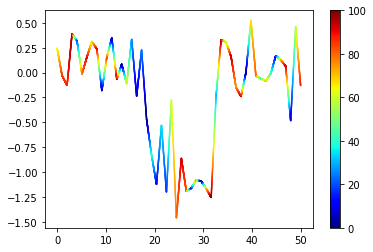

Index 3 ; True Class 0


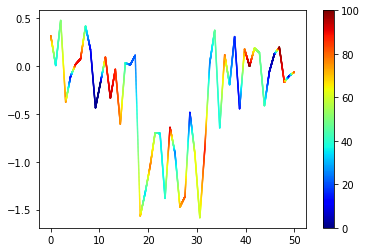

Index 4 ; True Class 0


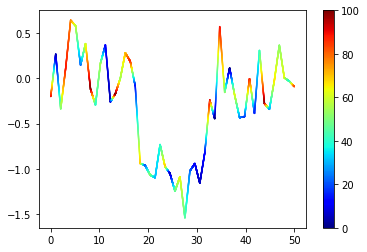

Index 5 ; True Class 0


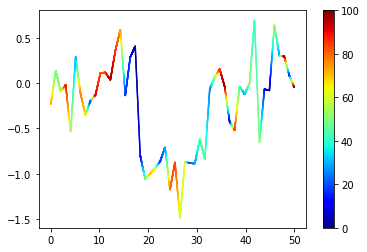

Index 6 ; True Class 1


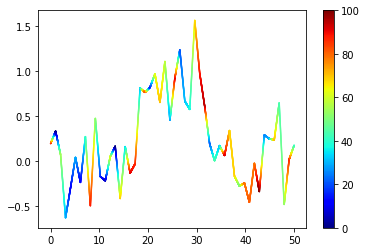

Index 7 ; True Class 0


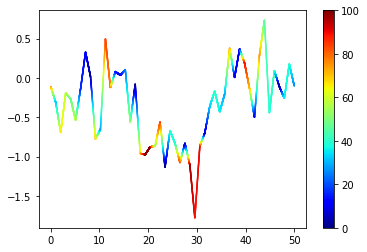

Index 8 ; True Class 0


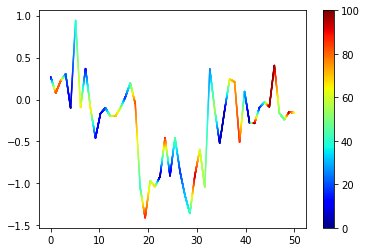

Index 9 ; True Class 0


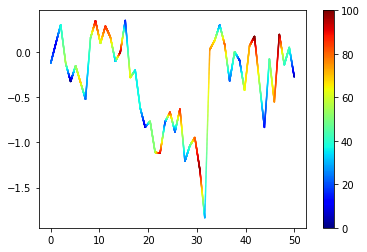

Index 10 ; True Class 0


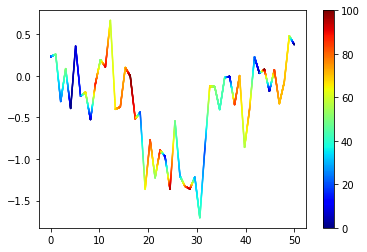

Index 11 ; True Class 0


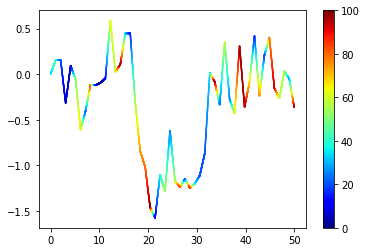

Index 12 ; True Class 1


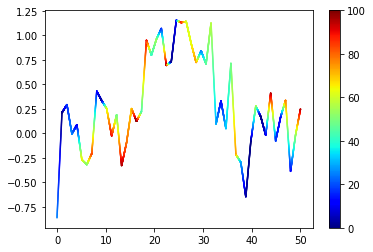

Index 13 ; True Class 1


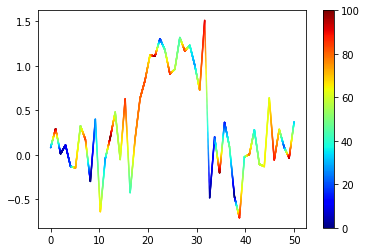

Index 14 ; True Class 0


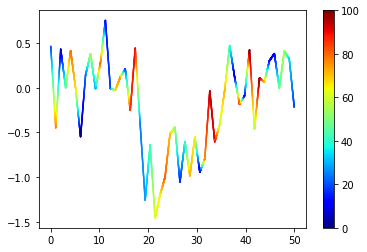

Index 15 ; True Class 1


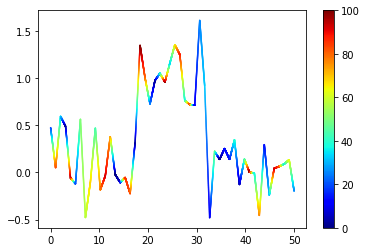

Index 16 ; True Class 1


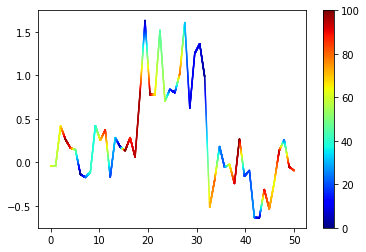

Index 17 ; True Class 0


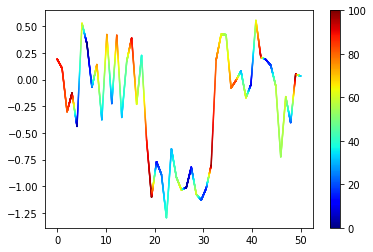

Index 18 ; True Class 0


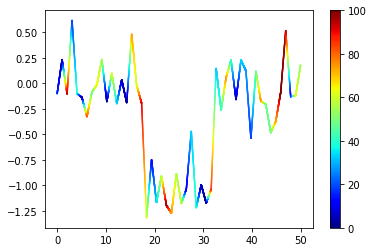

Index 19 ; True Class 0


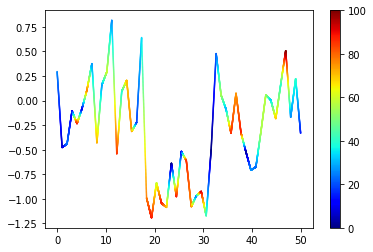

In [218]:
print(ds)
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
exp = weights[-1]
for i in range(len(X_test)+1):
    if i < 20:
        print('Index %d ; True Class %d' %(i,y_test[i]))
        vis.visualize_explanation(i,X_test,exp,ds=ds)


##### 3.4 Lime(MrSEQL) explanation

SmallMiddle_CAR
Index 0 ; True Class 0


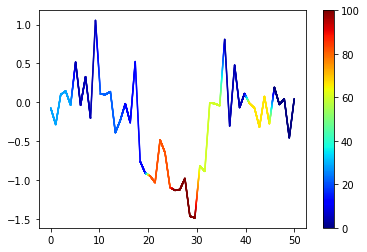

Index 1 ; True Class 0


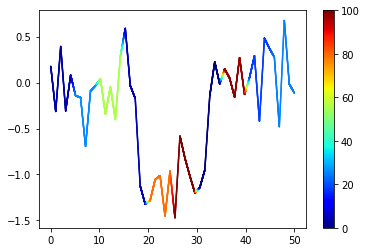

Index 2 ; True Class 0


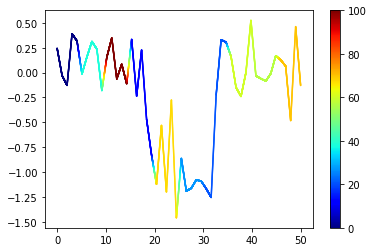

Index 3 ; True Class 0


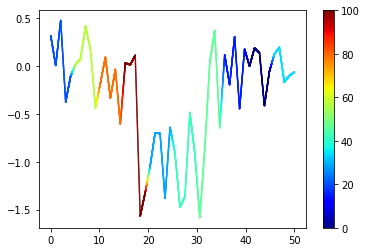

Index 4 ; True Class 0


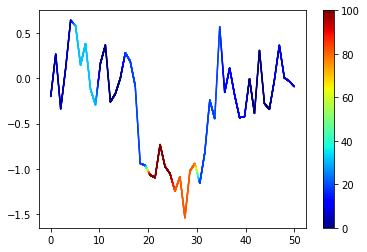

Index 5 ; True Class 0


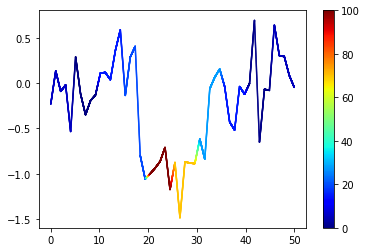

Index 6 ; True Class 1


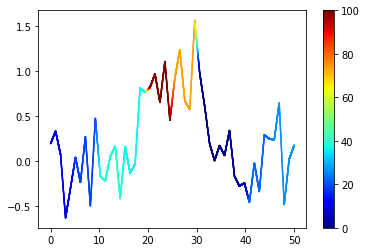

Index 7 ; True Class 0


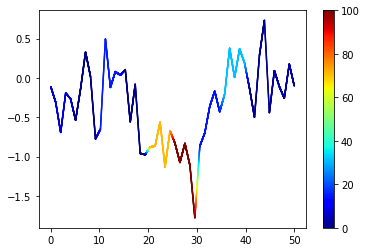

Index 8 ; True Class 0


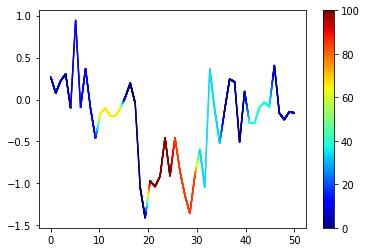

Index 9 ; True Class 0


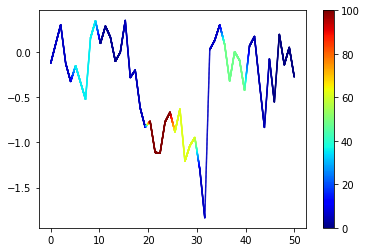

Index 10 ; True Class 0


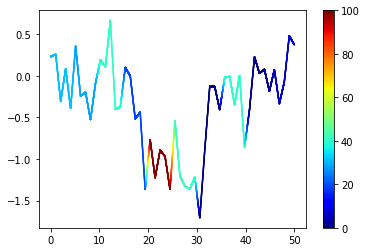

Index 11 ; True Class 0


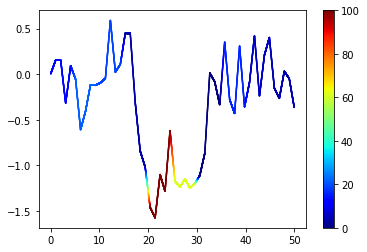

Index 12 ; True Class 1


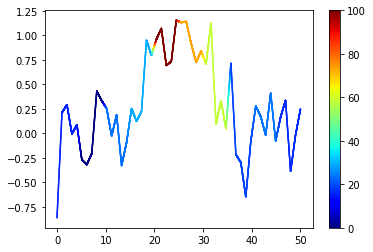

Index 13 ; True Class 1


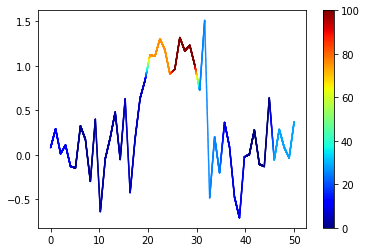

Index 14 ; True Class 0


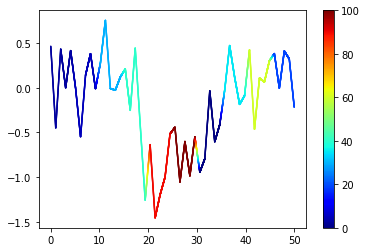

Index 15 ; True Class 1


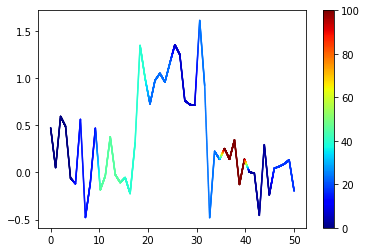

Index 16 ; True Class 1


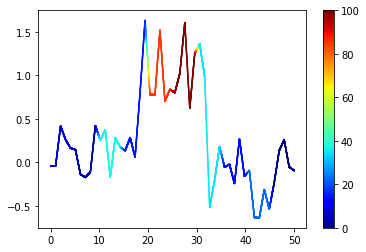

Index 17 ; True Class 0


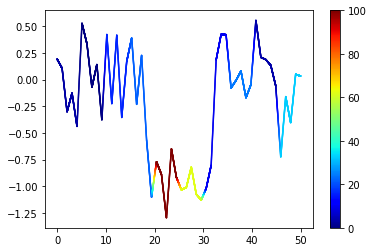

Index 18 ; True Class 0


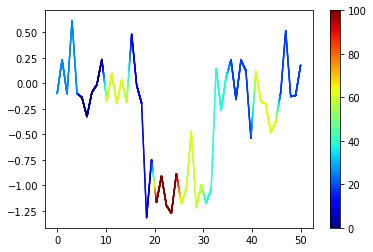

Index 19 ; True Class 0


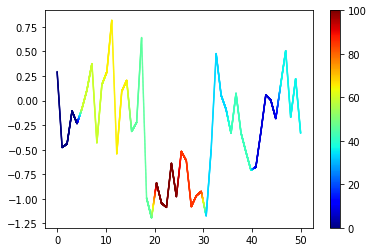

In [219]:
print(ds)
data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
exp = weights[0]
for i in range(len(X_test)+1):
    if i < 20:
        print('Index %d ; True Class %d' %(i,y_test[i]))
        vis.visualize_explanation(i,X_test,exp,ds=ds)


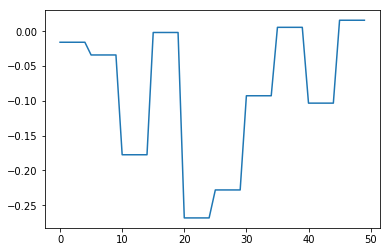

In [220]:
plt.plot(weights[0][8])